In [107]:
import sys
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import time
from typing import Union, List, Sequence, Optional
from tqdm import trange

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
import QES.general_python.common.binary as Binary
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import JAX_AVAILABLE, get_backend, get_global_logger
from QES.general_python.common.plot import Plotter

# ------------------------------------------------------------------
#! Lattice
from QES.general_python.lattices.lattice import LatticeBC, Lattice
from QES.general_python.lattices.honeycomb import HoneycombLattice
from QES.general_python.lattices.square import SquareLattice

# ------------------------------------------------------------------
#! Sampler
import QES.Solver.MonteCarlo.sampler as Sampler
import QES.NQS.nqs as NQS
import QES.NQS.tdvp as TDVP

# ------------------------------------------------------------------
#! ODE solver
from QES.general_python.common.ode import Euler, Heun, AdaptiveHeun, RK, ScipyRK

# ------------------------------------------------------------------
#! Networks
from QES.general_python.ml.net_impl.networks.net_rbm import RBM
from QES.general_python.ml.net_impl.networks.net_cnn import CNN
from QES.general_python.ml.net_impl.activation_functions import relu_jnp, tanh_jnp, sigmoid_jnp, leaky_relu_jnp, elu_jnp, poly6_jnp, softplus_jnp

# ------------------------------------------------------------------
#! Hamiltonians
from QES.general_python.algebra.linalg import act, overlap
from QES.Algebra.Model.dummy import DummyHamiltonian
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev import HeisenbergKitaev
from QES.Algebra.Model.Interacting.Spin.transverse_ising import TransverseFieldIsing

# ------------------------------------------------------------------
#! Linear algebra
import QES.general_python.algebra.solvers.stochastic_rcnfg as SR
import QES.general_python.algebra.solvers as solvers
import QES.general_python.algebra.preconditioners as preconditioners

# ------------------------------------------------------------------

#! Spin operators
import QES.Algebra.Operator.operators_spin as op_spin
#! Fermionic operators
import QES.Algebra.Operator.operators_spinless_fermions as op_sferm

#! Backends
if JAX_AVAILABLE:
    import jax
    import jax.numpy as jnp
else:
    jax = None
    jnp = None
    
# ------------------------------------------------------------------
lattice_type        = 'honeycomb'
lx, ly, lz          = 4, 8, 1
# ------------------------------------------------------------------
ode_solver_type     = 'Euler'
# ode_solver_type   = 'Heun'
# ode_solver_type   = 'AdaptiveHeun'
# ode_solver_type   = 'RK4'
lr                  = 0.02 # is also dt
# ------------------------------------------------------------------
network_type        = 'RBM'
# network_type        = 'CNN'
alpha               = 2
# ------------------------------------------------------------------
ham_type            = 'HeisenbergKitaev'
# ham_type            = 'TransverseFieldIsing'
# ham_type            = 'DummyHamiltonian'
ham_dtype           = jnp.float64
# ------------------------------------------------------------------

logger              = get_global_logger()
backend             = 'jax'
seed                = 1234
dtypex              = jnp.complex128
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

# ------------------------------------------------------------------


### Lattice interface

In [112]:
if lattice_type == 'square':
    lattice     = SquareLattice(
                        dim = 2, 
                        lx  = lx,
                        ly  = ly,
                        lz  = lz,
                        bc  = LatticeBC.PBC
                    )
elif lattice_type == 'honeycomb':
    lattice     = HoneycombLattice(
                        dim = 2,
                        lx  = lx,
                        ly  = ly,
                        lz  = lz,
                        bc  = LatticeBC.PBC
                    )
else:
    raise ValueError(f"Unknown lattice type: {lattice_type}")
ns          = lattice.ns
mult        = lattice.ns // (lx * ly * lz)
st_shape    = (ns, )

for i in range(lattice.ns):
    neighbors = lattice.get_nn_forward_num(i)
    logger.info(f"Neighbors of site {i}: {neighbors}", lvl = 1, color = 'green')
    for j in range(neighbors):
        nei_in = lattice.get_nn_forward(i, j)
        logger.info(f"Neighbor {j} of site {i}: {nei_in}", lvl = 2, color = 'blue')


lattice

14_05_2025_17-47_21 [INFO] 	->Neighbors of site 0: 3
14_05_2025_17-47_21 [INFO] 		->Neighbor 0 of site 0: -1
14_05_2025_17-47_21 [INFO] 		->Neighbor 1 of site 0: -1
14_05_2025_17-47_21 [INFO] 		->Neighbor 2 of site 0: 1
14_05_2025_17-47_21 [INFO] 	->Neighbors of site 1: 3
14_05_2025_17-47_21 [INFO] 		->Neighbor 0 of site 1: 8
14_05_2025_17-47_21 [INFO] 		->Neighbor 1 of site 1: 2
14_05_2025_17-47_21 [INFO] 		->Neighbor 2 of site 1: -1
14_05_2025_17-47_21 [INFO] 	->Neighbors of site 2: 3
14_05_2025_17-47_21 [INFO] 		->Neighbor 0 of site 2: -1
14_05_2025_17-47_21 [INFO] 		->Neighbor 1 of site 2: -1
14_05_2025_17-47_21 [INFO] 		->Neighbor 2 of site 2: 3
14_05_2025_17-47_21 [INFO] 	->Neighbors of site 3: 3
14_05_2025_17-47_21 [INFO] 		->Neighbor 0 of site 3: 10
14_05_2025_17-47_21 [INFO] 		->Neighbor 1 of site 3: 4
14_05_2025_17-47_21 [INFO] 		->Neighbor 2 of site 3: -1
14_05_2025_17-47_21 [INFO] 	->Neighbors of site 4: 3
14_05_2025_17-47_21 [INFO] 		->Neighbor 0 of site 4: -1
14_05_2025_1

HON,LatticeBC.PBC,d=2,Ns=64,Lx=4,Ly=8,Lz=1

In [113]:
sig_z = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [1]
)

sig_x = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [1]
)

sig_z_c = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 3]
)

sig_x_c = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 3]
)

### Hamiltonian - Hamiltonian operator $H$ and its expectation value $\langle H \rangle$.

In [114]:
if ham_type == 'HeisenbergKitaev':
    hamil = HeisenbergKitaev(lattice    = lattice,
                        hilbert_space   = None,
                        hx              = 0.5,
                        hz              = -0.3,
                        kx              = 1.0,
                        ky              = 1.0,
                        kz              = 1.0,
                        j               = 1.0,
                        dlt             = 1.0,
                        dtype           = ham_dtype,
                        backend         = backend)

elif ham_type == 'TransverseFieldIsing':
    hamil = TransverseFieldIsing(
                        lattice        = lattice,
                        hilbert_space  = None,
                        hx             = 0.5,
                        hz             = -0.3,
                        dtype          = ham_dtype,
                        backend        = backend
                )
elif ham_type == 'DummyHamiltonian':
    hamil = DummyHamiltonian(
                        lattice        = lattice,
                        hilbert_space  = None,
                        dtype          = ham_dtype,
                        backend        = backend
                )
else:
    raise ValueError(f"Unknown Hamiltonian type: {ham_type}")

logger.title('Hamiltonian', desired_size=150, fill='#', color='red')


14_05_2025_17-47_51 [INFO] 		->[Hamiltonian] The type of the lattice HON,LatticeBC.PBC,d=2,Ns=64,Lx=4,Ly=8,Lz=1 is not standard. Check your intentions...
14_05_2025_17-47_51 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier -0.3
14_05_2025_17-47_51 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier 0.5
14_05_2025_17-47_51 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 1.0
14_05_2025_17-47_51 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 1.0
14_05_2025_17-47_51 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator 

In [115]:
if hamil.hilbert_size <= 2**20:
    time0   = time.time()
    hamil.build(use_numpy=True)
    time1   = time.time()
    logger.info(f"Time to build Hamiltonian: {time1 - time0:.2f} seconds", color='green')
    
    if hamil.hilbert_size <= 2**12:
        hamil.diagonalize()
    else:
        hamil.diagonalize(method = 'lanczos', k = 50)
    time2   = time.time()
    logger.info(f"Time to diagonalize Hamiltonian: {time2 - time1:.2f} seconds", color='blue')
    eigv    = hamil.get_eigval()
    
    #! Test the operator expectation in the ground state
    if hamil.hilbert_size <= 2**12:
        gs              = hamil.get_eigvec(0)
        sig_x_op_mat    = sig_x.matrix(dim = hamil.hilbert_size, matrix_type = 'sparse', use_numpy = True)
        sig_z_op_mat    = sig_z.matrix(dim = hamil.hilbert_size, matrix_type = 'sparse', use_numpy = True)
        sig_x_op_mat_c  = sig_x_c.matrix(dim = hamil.hilbert_size, matrix_type = 'sparse', use_numpy = True)
        sig_z_op_mat_c  = sig_z_c.matrix(dim = hamil.hilbert_size, matrix_type = 'sparse', use_numpy = True)
        
        sig_x_exp       = overlap(gs, gs, sig_x_op_mat, backend = np)
        sig_z_exp       = overlap(gs, gs, sig_z_op_mat, backend = np)
        sig_x_exp_c     = overlap(gs, gs, sig_x_op_mat_c, backend = np)
        sig_z_exp_c     = overlap(gs, gs, sig_z_op_mat_c, backend = np)
        logger.info(f"sig_x expectation value: {sig_x_exp:.4f}", color='green')
        logger.info(f"sig_z expectation value: {sig_z_exp:.4f}", color='green')
        logger.info(f"sig_x expectation value (c): {sig_x_exp_c:.4f}", color='green')
        logger.info(f"sig_z expectation value (c): {sig_z_exp_c:.4f}", color='green')
else:
    eigv = None

#### Plot if needed

In [116]:
if eigv is not None:
    fig, ax = Plotter.get_subplots(
        nrows       = 1,
        ncols       = 1,
        figsize     = (4, 3),
        dpi         = 100,
    )
    x   = np.arange(0, len(eigv))
    y   = eigv
    ax[0].plot(x, y, 'o', markersize=2)
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Eigenvalue')
    ax[0].axhline(eigv[0], color='r', linestyle='--', label=f'Ground state {eigv[0]:.3e}')
    ax[0].legend()

### Network - variational ansatz body $\psi _\theta (s)$ and its gradient $\nabla \psi _\theta (s)$.

In [117]:
if network_type == 'RBM':
    net = RBM(
        input_shape     = st_shape, 
        n_hidden        = int(alpha * ns),
        dtype           = dtypex,
        param_dtype     = dtypex,
        seed            = seed,
        visible_bias    = False,
        bias            = True,
    )
elif network_type == 'CNN':
    net     = CNN(
        input_shape         = st_shape,
        reshape_dims        = (lx, ly * mult),
        features            = (8,) * alpha,
        kernel_sizes        = [(3, 3)] * alpha,
        activations         = [elu_jnp] * alpha,
        dtype               = dtypex,
        param_dtype         = dtypex,
        final_activation    = elu_jnp,
        seed                = seed,
        output_shape        = (1,)
    )
else:
    raise ValueError(f"Unknown network type: {network_type}")
net

14_05_2025_17-47_54 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
14_05_2025_17-47_54 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=8320, is_holomorphic=True


ComplexRBM(shape=(64,), hidden=128, bias=on, visible_bias=off, dtype=complex128, params=8320, analytic_grad=False, initialized)

### Sampler - sampling from the distribution $p_\theta (s)$.

In [119]:
n_chains        = 10
n_samples       = 500
n_therm_steps   = 25
sampler         = Sampler.MCSampler(
                    net             = net,
                    shape           = st_shape,
                    rng             = rng,
                    rng_k           = rng_k,
                    numchains       = n_chains,
                    numsamples      = n_samples,
                    sweep_steps     = ns,
                    backend         = backend_np,
                    therm_steps     = n_therm_steps,
                    mu              = 2.0,
                    seed            = seed,
                    dtype           = dtypex,
                )
sampler

MCSampler(shape=(64,), mu=2.0, beta=1.0, therm_steps=25, sweep_steps=64, numsamples=500, numchains=10, backend=jax)

### Stepper - TDVP stepper for the time evolution of the state $\psi _\theta (s)$.

In [120]:
if ode_solver_type == 'Euler':
    ode_solver = Euler(
        backend         = backend_np,
        dt              = lr, 
        rhs_prefactor   = -1.0,
    )
elif ode_solver_type == 'Heun':
    ode_solver = Heun(
        backend         = backend_np,
        dt              = lr,
        rhs_prefactor   = -1.0,
    )
elif ode_solver_type == 'AdaptiveHeun':
    ode_solver = AdaptiveHeun(
        backend         = backend_np,
        dt              = lr,
        rhs_prefactor   = -1.0,
    )
else:
    raise ValueError(f"Unknown ODE solver: {ode_solver_type}")
ode_solver

Euler(dt=0.02, backend=<module 'jax.numpy' from '/home/klimak/libraries/anaconda3/lib/python3.11/site-packages/jax/numpy/__init__.py'>, rhs_p=-1.0)

### NQS - neural network quantum state $\psi_\theta (s)$ and its gradient $\nabla \psi_\theta (s)$.

In [122]:
n_epo           = 1000
n_sweep_steps   = ns
n_batch         = 100

# Other
reg             = 5
maxiter         = 1000
tolerance       = 1e-8
use_min_sr      = False

# Solver
solver_id       = solvers.SolverType.SCIPY_CG
precond_id      = preconditioners.PreconditionersTypeSym.JACOBI
precond         = preconditioners.choose_precond(precond_id=precond_id, sigma=reg, backend=backend_np)
# precond_id      = None

tdvp = TDVP.TDVP(
    use_sr          = True,
    use_minsr       = False,
    rhs_prefact     = 1.0,
    sr_lin_solver   = solver_id,
    sr_precond      = precond,
    sr_pinv_tol     = tolerance,
    sr_pinv_cutoff  = 1e-8,
    sr_snr_tol      = tolerance,
    sr_diag_shift   = reg,
    sr_lin_solver_t = solvers.SolverForm.GRAM,
    sr_maxiter      = maxiter,
    backend         = backend_np
)
tdvp

14_05_2025_17-48_11 [INFO] 	->[Jacobi Preconditioner] Resetting backend to: <module 'jax.numpy' from '/home/klimak/libraries/anaconda3/lib/python3.11/site-packages/jax/numpy/__init__.py'>
Using Gram solver
14_05_2025_17-48_11 [INFO] 		->[Jacobi Preconditioner] JIT compiling apply_gram(r, S, Sp, ...) function...


TDVP(backend=jax, use_sr=True, use_minsr=False, rhs_prefact=1.0, sr_snr_tol=1e-08, sr_pinv_tol=1e-08, sr_diag_shift=5, sr_maxiter=1000)

In [123]:
nqs =   NQS.NQS(
            net             = net,
            sampler         = sampler,
            hamiltonian     = hamil,
            lower_betas     = None,
            lower_states    = None,
            seed            = seed,
            beta            = 1.0,
            mu              = sampler.get_mu(),
            shape           = st_shape,
            backend         = backend_np,
            nthread         = 1,
            batch_size      = n_batch,
            dtype           = dtypex,  
        )
nqs.reset()
ansatz          = nqs.ansatz
loc_energy      = nqs.local_energy
flat_grad       = nqs.flat_grad
nqs

14_05_2025_17-48_12 [ERROR] 		->[<class 'QES.NQS.nqs.NQS'>] Preconditioner not used: name 'precond_mod' is not defined
14_05_2025_17-48_12 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
14_05_2025_17-48_12 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=8320, is_holomorphic=True
14_05_2025_17-48_12 [INFO] 	->[GeneralNet] Network <class 'QES.general_python.ml.net_impl.networks.net_rbm.RBM'> initialized with forced init.


[1] I am a NQS object with a general Monte Carlo Solver at β =  1.00.

### Test the training of the NQS with a simple Hamiltonian.

In [124]:
_single_step_jax = nqs.wrap_single_step_jax(
    #! JAX options
    apply_fn             = ansatz,
    local_energy_fun     = loc_energy,
    flat_grad_fun        = flat_grad,
    batch_size           = n_batch
)

#! Training
def single_step_train(i: int, t = 0, reset: bool=False):
    
    #! 1) Sampling
    ((_, _), (configs, configs_ansatze), probabilities), t_sample = timeit(nqs.sample, reset=reset)

    #! 2) Energy + gradient (JIT-compiled)
    params = nqs.get_params(unravel=True)
    
    (dpar, lr, (step_info, (shapes, sizes, iscpx))), t_step = timeit(ode_solver.step,
                            f               = tdvp,
                            y               = params,
                            t               = t,
                            est_fn          = _single_step_jax,
                            configs         = configs,
                            configs_ansatze = configs_ansatze,
                            probabilities   = probabilities
                            )
    # if step_info.failed:
    #     logger.error(f"Step {i} failed.")
    #     return None, None, (t_sample, t_step, 0.0)

    #! 3) Parameter update
    _, t_update = timeit(nqs.set_params, dpar, shapes=shapes, sizes=sizes, iscpx=iscpx)
    return (step_info.mean_energy, step_info.std_energy), (t_sample, t_step, t_update)

def train_function(n_epo : int, reset : bool = False):

    history      = np.zeros(n_epo, dtype=np.float64)
    history_std  = np.zeros(n_epo, dtype=np.float64)
    times_samp   = np.zeros(n_epo, dtype=np.float64)
    times_step   = np.zeros(n_epo, dtype=np.float64)
    times_update = np.zeros(n_epo, dtype=np.float64)
    pbar         = trange(n_epo, desc="Training", leave=True)

    for i in pbar:

        (mean_E, std_E), (t_s, t_st, t_u) = single_step_train(i, t=0, reset=reset)
        if mean_E is None:
            logger.warning(f"Stopped at epoch {i} due to failure.")
            break

        # Log & display
        times_samp[i], times_step[i], times_update[i]   = t_s, t_st, t_u
        history[i], history_std[i]                      = np.real(mean_E), np.real(std_E)

        pbar.set_postfix({
            "E_mean"        :  f"{mean_E:.4e}",
            "lr"            :  f"{ode_solver.dt(0, 0):.1e}",
            "t_sample"      :  f"{t_s:.3e}s",
            "t_step"        :  f"{t_st:.3e}s",
            "t_update"      :  f"{t_u:.3e}s",
            "t_tot"         :  f"{(t_s+t_st+t_u):.3e}s",
        }, refresh=True)

        if np.isnan(mean_E) or np.isnan(std_E):
            logger.warning(f"NaN detected at epoch {i}.")
            break

    # At the end, you can quickly see where time went:
    total = times_samp + times_step + times_update
    print("Time breakdown (fraction of total):")
    print(f"-sampling: {times_samp.sum()/total.sum():.2%}")
    print(f"-compute:  {times_step.sum()/total.sum():.2%}")
    print(f"-update:   {times_update.sum()/total.sum():.2%}")

    return (history[:i+1],
            history_std[:i+1],
            total[:i+1])

In [125]:
# from jax.experimental import profiler
# profiler

history, history_std, epoch_times = train_function(
            n_epo       = n_epo,
            reset       = True,
            )
# profiler.stop_trace()


Training:  26%|██▋       | 264/1000 [5:03:06<12:36:28, 61.67s/it, E_mean=nan+nanj, lr=2.0e-02, t_sample=7.275e+00s, t_step=1.844e+00s, t_update=2.718e-04s, t_tot=9.119e+00s]               

14_05_2025_22-52_03 [WARNING] NaN detected at epoch 264.


Training:  26%|██▋       | 264/1000 [5:03:06<14:05:02, 68.89s/it, E_mean=nan+nanj, lr=2.0e-02, t_sample=7.275e+00s, t_step=1.844e+00s, t_update=2.718e-04s, t_tot=9.119e+00s]

Time breakdown (fraction of total):
-sampling: 12.10%
-compute:  87.89%
-update:   0.00%


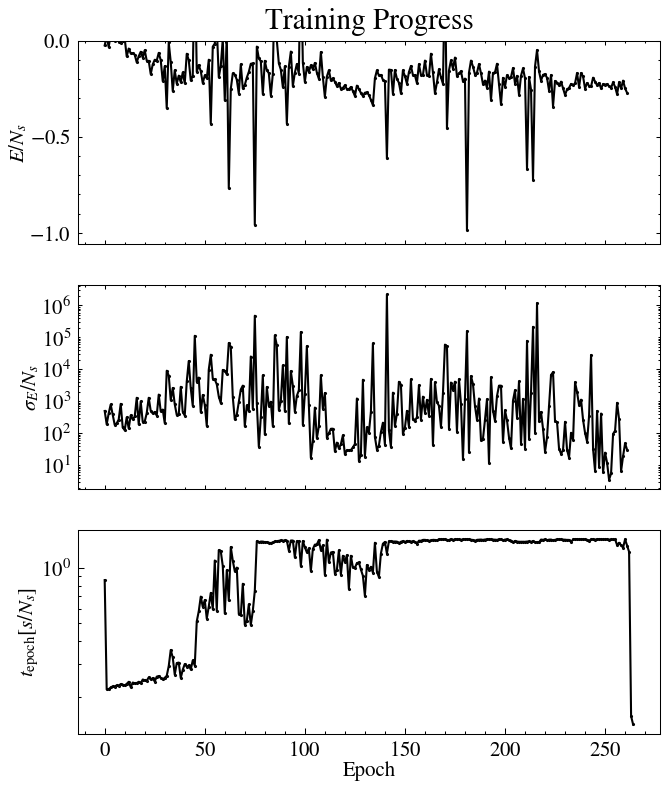

In [126]:
energies        = history[~np.isnan(history)][:-2]
energies_std    = history_std[~np.isnan(history_std)][:-2]
fig, ax         = Plotter.get_subplots(nrows=3, ncols=1, figsize=(5, 6), dpi=150, sharex=True)
Plotter.plot(ax[0], x=np.arange(len(energies)), y=np.real(energies) / lattice.ns, marker="o", markersize=0.5, lw=1)
if eigv is not None:
    ax[0].axhline(eigv[0] / lattice.ns, color='r', linestyle='--', label=f'Ground state {eigv[0] / lattice.ns:.3e}')
    ax[0].legend()
Plotter.set_ax_params(ax[0], title="Training Progress", ylabel=r"$E/N_s$", ylim=(None, 0))
Plotter.set_tickparams(ax[0], maj_tick_l=2, min_tick_l=1)

Plotter.plot(ax[1], x=np.arange(len(energies_std)), y=np.real(energies_std) / lattice.ns, marker="o", markersize=0.5, lw=1)
Plotter.set_ax_params(ax[1], ylabel=r"$\sigma_E/N_s$", yscale="log")
Plotter.set_tickparams(ax[1], maj_tick_l=2, min_tick_l=1)

Plotter.plot(ax[2], x=np.arange(len(epoch_times)), y=np.real(epoch_times) / lattice.ns, marker="o", markersize=0.5, lw=1)
Plotter.set_ax_params(ax[2], xlabel="Epoch", ylabel=r"$t_{\rm epoch} [s / N_s]$", yscale="log")

In [ ]:
#! Spin operators
(_, _), (configs, configs_ansatze), probabilities = nqs.sample(500, 50)

(states, ansatze), probabilities, output = nqs.evaluate_fun(
    functions       =   [sig_z.jax, sig_x.jax, sig_z_c.jax, sig_x_c.jax],
    states_and_psi  =   (configs, configs_ansatze),
    probabilities   =   probabilities,
)

_, _, output_e = nqs.evaluate_fun(
    functions       =   None,
    states_and_psi  =   (configs, configs_ansatze),
    probabilities   =   probabilities,
)


x, y, output_e_b = nqs.evaluate_fun_jax(
    func            = hamil.get_loc_energy_jax_fun(),
    states          = configs,
    probabilities   = probabilities,
    logproba_in     = configs_ansatze,
    logproba_fun    = nqs.ansatz,
    parameters      = nqs.get_params(),
    batch_size      = 10
)

print(x)

[14.5383339 +0.67130298j  9.17076602-0.18515113j 14.5383339 +0.67130298j
 ...  6.18745309-1.10701846j -3.2632066 +0.00746073j
 -3.2632066 +0.00746073j]


In [ ]:
means   = [x[1] for x in output]
stds    = [x[2] for x in output]
ops     = ['sig_z', 'sig_x', 'sig_z_c', 'sig_x_c']
colors  = ['red', 'blue', 'green', 'orange']
for i, op in enumerate(ops):
    logger.info(f"{op} expectation value: {means[i]:.4f} ± {stds[i]:.4f}", color=colors[i])

print("Output energy: ", output_e[1] / lattice.ns, "±", output_e[2] / lattice.ns)
print("Output energy (batch): ", y / lattice.ns, "±", output_e_b / lattice.ns)

14_05_2025_01-59_45 [INFO] sig_z expectation value: 0.1687+0.0000j ± 0.4707
14_05_2025_01-59_45 [INFO] sig_x expectation value: 0.0772+0.0653j ± 18.5549
14_05_2025_01-59_45 [INFO] sig_z_c expectation value: -0.0776+0.0000j ± 0.2377
14_05_2025_01-59_45 [INFO] sig_x_c expectation value: 0.2796-0.0083j ± 2.1677
Output energy:  (0.7830516803363646+0.00518963748057365j) ± 7.476518312079096
Output energy (batch):  (0.7830516803363639+0.005189637480573528j) ± 7.476518312079096


In [ ]:
# 13_05_2025_22-24_25 [INFO] sig_x expectation value: -0.0001
# 13_05_2025_22-24_25 [INFO] sig_z expectation value: 0.0001
# 13_05_2025_22-24_25 [INFO] sig_x expectation value (c): -0.1323
# 13_05_2025_22-24_25 [INFO] sig_z expectation value (c): -0.1361